# How To Use Vertex Text-to-Image Generative AI To Perform Product Image Editing

This notebook outlines how to interact with Vertex AI's Text-to-Image GenAI models to create dynamic content using Outpainting. With Imagen on Vertex AI, developers can utilize next-generation AI products to transform their imagination into high quality visual assets, in seconds. With just some simple lines of Python, we can merge these assets with existing content to provide a new level of visual website content.

## Prepare the python development environment

First, let's identify any project specific variables to customize this notebook to your GCP environment. Change YOUR_PROJECT_ID with your own GCP project ID.

In [16]:
PROJECT_ID = "rkiles-demo-host-vpc"

Install any needed python modules from our requirements.txt file. Most Vertex Workbench environments include all the packages we'll be using, but if you are using an external Jupyter Notebook or require any additional packages for your own needs, you can simply add them to the included requirements.txt file an run the folloiwng commands.

In [17]:
#pip install -r requirements.txt

Now we will import all required modules. For our purpose, we will be utilizing the following:

- google.auth - Provides authentication access to the Google API's, such as imagegeneration:predict
- PIL - An easy to use Python image library to help build the background for our banner and perform image layering
- io - Core python libray used to work with I/O. We will use this to help convert strings to byte objects for PIL
- base64 - Imagen API requests return generated or edited images as base64-encoded strings. This module will help us decode this data to an image file
- requests - This module will allow us to interact directly with Imagen over the REST API. 
- json - Python module used to interact with JSON data. Imagen returns results in json format.

In [18]:
import vertexai
from vertexai.preview.vision_models import Image, ImageGenerationModel
from vertexai.generative_models import GenerativeModel, GenerationConfig, Part, Tool, ChatSession, FunctionDeclaration
from vertexai.preview.generative_models import grounding
import base64
import json
import yaml

## Authenticate to the Vertex AI API

Our Vertex Workbench instance is configured to use a specified service account that has IAM access to the text-to-vision API. The following two secitons will allow us to generate the access token we will pass as an authorization bearer token later in the header.

In [19]:
project_id = "rkiles-demo-host-vpc"
region = "us-central1"
location = "global"

input_file = "couch.png"
output_file = "results.png"
prompt = "Inspect this image an generate a prompt I can use with Imagen to create a background"

## Inspect the base image and generate the Imagen Prompt

Define the Gemini configuration parameters

In [20]:
inspect_agent_config = GenerationConfig(
    response_mime_type = "text/plain",
    #response_mime_type = "application/json",
    temperature=1,
    #top_p=0.2,
    #top_k=2,
    #candidate_count=1,
    #max_output_tokens=8192,
    #response_schema=response_schema
)

Next we will define the system instructions for the model. In this example we will instruct the model to inspect the base image and generate a promt to be used with Imagen.

In [21]:
inspect_agent_sys_instruct = f'''
<PERSONA>
You are a professional photographer and Generative AI specialist. You are highly skilled at inspecting picture and writing detailed prompts to be used with Vertex AI Imagen.
</PERSONA>

<CONTEXT>
You will be provided with an image. 
Analyze the image and identify its key features, including objects, composition, colors, lighting, and style. 
Imagen's Product Image Editing allows users to realistically edit product images using text prompts. With it, you can make changes to lighting, shadows, backgrounds, and even add or remove objects, all while maintaining the product's core appearance and quality. It aims to simplify and streamline the product photography editing process.
</CONTEXT>

<OBJECTIVE>
Your goal is to generate a prompt for Google's Vertex AI Imagen to perform Product Image Editing with this image.
The generated image will consist of this product placed in a setting that would accompany the product.
The prompt should be clear, concise, and detailed enough to allow Imagen to produce a high-quality, stylistically modified version of the input image.  
Include specific instructions for art style options within the prompt.
</OBJECTIVE>

<OUTPUT>
Only generate the prompt.
Your response is part of an automated process and will be sent directly to Imagen.
'''


In [22]:
inspect_agent_model = GenerativeModel(
    "gemini-1.5-flash-002",
    generation_config=inspect_agent_config,
    system_instruction=[inspect_agent_sys_instruct],
)

Load the image file

In [23]:
with open(input_file, "rb") as f:
    encoded_base_image = base64.b64encode(f.read())
B64_BASE_IMAGE = encoded_base_image.decode('utf-8')

Generate the prompt

In [24]:
inspect_agent = inspect_agent_model.generate_content([Part.from_data(data=base64.b64decode(B64_BASE_IMAGE), mime_type="image/png"),prompt])

In [25]:
print(inspect_agent.text)

A light beige modern sectional sofa,  placed in a bright, airy living room with large windows letting in soft natural light. The floor is light oak hardwood, and a simple, off-white wool rug is under the sofa.  There is a minimalist coffee table made of light wood with a simple glass top in front of the sofa.  A single, large potted plant (a fiddle leaf fig) is positioned in the corner near the sofa. The overall style is minimalist Scandinavian with a touch of modern farmhouse.  Render in a photorealistic style with soft, natural lighting and subtle shadows.  The image should evoke a sense of calm and serenity.



## Generate the Image

Initiate Vertex

In [26]:
vertexai.init(project=PROJECT_ID, location=region)

Define the model and the base image.

In [28]:
#model = ImageGenerationModel.from_pretrained("imagegeneration@006")
model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")
base_img = Image.load_from_file(location=input_file)

Submit the base image and prompt to generate a new image.

In [29]:
images = model.edit_image(
    base_image=base_img,
    prompt=inspect_agent.text,
    edit_mode="product-image",
)

View the generated image.

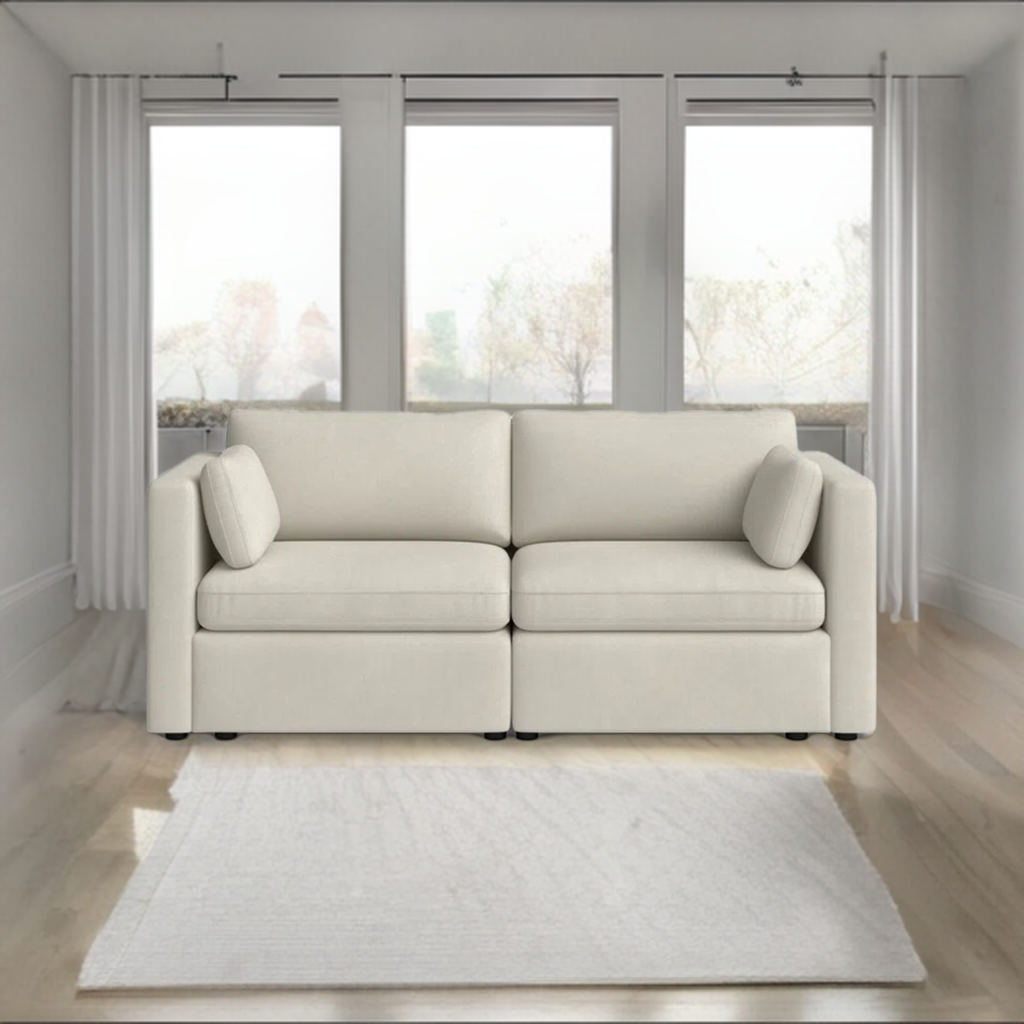

In [30]:
images[0].show()

Uncomment the following command to save the generated image

In [15]:
images[0].save(location=output_file, include_generation_parameters=False)